### Read the input files to do some descriptive analysis and visualization

In [7]:
import sys
sys.path.append('eval/')

import datetime 
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import CRS

import util_plot
from setup import *

%matplotlib inline
plt.rcParams.update({'font.size': 10})
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [3]:
period = 'before'
dates = pd.read_csv(data_dir+period+"_dates.csv")

In [4]:
rail = pd.read_csv(data_dir+"data_processed/rail_catchment/"+period+"/rail_df.csv")
bus = pd.read_csv(data_dir+"data_processed/rail_catchment/"+period+"/bus_rail_df.csv")
tnc = pd.read_csv(data_dir+"data_processed/rail_catchment/"+period+"/tnc_rail_df.csv")

# Time Series

In [5]:
df = rail
df['day'] = df['ts'] // 96
df = df.groupby(['day','station_id'], as_index=False).sum()
df = df.sort_values(by='day')
downtown_stations = pd.read_csv(data_dir+"data_processed/downtown_stations.csv")
df = df[df['station_id'].isin(downtown_stations['STATION_ID'].tolist())]

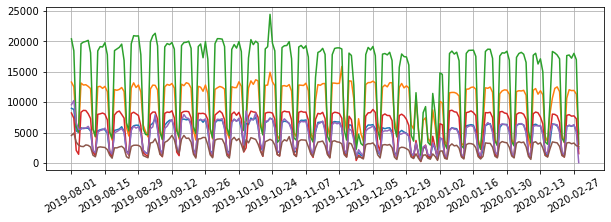

In [9]:
fig, ax = plt.subplots(figsize=(10,3))
for station_id, grp in df.groupby('station_id'):
    r = np.random.rand()
    if r < 0.2:
        ax.plot(dates.iloc[grp['day'].to_numpy()]['day'], grp['count'])#/grp['count'].max())
ax.set_xticks(np.arange(0,len(grp),14))
ax.set_xticklabels(pd.date_range(start="2019-08-01",end="2020-02-29", freq='14D').date, rotation=30)
ax.grid()

In [10]:
dfB = bus
dfB['day'] = dfB['ts'] // 96
dfB = dfB.groupby(['day','STATION_ID'], as_index=False).sum()
dfB = dfB.sort_values(by='day')
downtown_stations = pd.read_csv(data_dir+"data_processed/downtown_stations.csv")
dfB = dfB[dfB['STATION_ID'].isin(downtown_stations['STATION_ID'].tolist())]
dfB = dfB.groupby('day').sum()


dfT = tnc
dfT['day'] = dfT['ts'] // 96
dfT = dfT.groupby(['day','STATION_ID'], as_index=False).sum()
dfT = dfT.sort_values(by='day')
downtown_stations = pd.read_csv(data_dir+"data_processed/downtown_stations.csv")
dfT = dfT[dfT['STATION_ID'].isin(downtown_stations['STATION_ID'].tolist())]
dfT = dfT.groupby('day').sum()


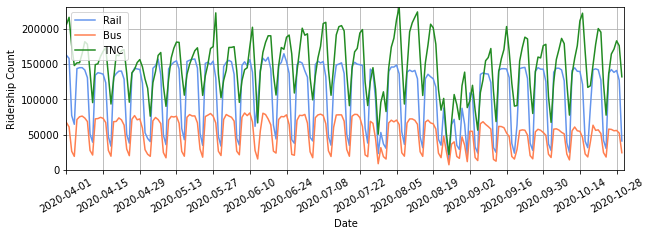

In [11]:
df = df.groupby('day').sum()
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['count'], color='cornflowerblue',label='Rail')
ax.plot(dfB['bus_count'], color='coral', label='Bus')
ax.plot(dfT['tnc_count'], color='forestgreen', label = 'TNC')
ax.set_xlim([0,len(df)])
ax.set_ylim([0,dfT['tnc_count'].max()])
ax.set_xticks(np.arange(0,len(df),14))
ax.set_xticklabels(pd.date_range(start="2020-04-01",end="2020-10-31", freq='14D').date, rotation=30)
ax.set_ylabel("Ridership Count")
ax.set_xlabel("Date")
ax.legend()
ax.grid()
fig.savefig(data_dir+"data_processed/"+period+"_demand_viz.png", bbox_inches='tight')

# Spatial Balance

In [12]:
stations = gpd.read_file(data_dir+"data_raw/CTA_Rail/CTA_RailStations.shp")
stations = stations.to_crs(CRS("epsg:4326"))
chicago = (stations.geometry.x.min(), stations.geometry.y.min(), stations.geometry.x.max(), stations.geometry.y.max())
downtown = (-87.645168, 41.872034, -87.623921,  41.889749)

In [13]:
def plot(stations, df, merge_cols_left, merge_cols_right, value_col, title): 
    temp = pd.merge(stations, df, left_on=merge_cols_left, right_on=merge_cols_right)
    scheme = mc.Quantiles(temp[value_col], k=5)
    
    a = gplt.pointplot(temp, projection=gcrs.WebMercator(),
                  hue=value_col, scale=value_col, limits=(5,30), scheme=scheme, legend=True, legend_var='hue',
                  legend_kwargs={'bbox_to_anchor': (1, 0.5), 'frameon': True})
    gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=chicago)
    # this patch won't show up with webmap, need to investigate further
    #plt.gca().add_patch(Rectangle((-87.645168, 41.872034),0.021247,0.017715,linewidth=5,edgecolor='r',facecolor='r'))
    plt.title(title)

    plt.savefig(data_dir+title+".png", bbox_inches='tight')
    a = gplt.pointplot(temp, projection=gcrs.WebMercator(), hue=value_col, scale=value_col, limits=(5,30), 
                       scheme=scheme, legend=False)
    gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=downtown)
    plt.title('Downtown Zoom')
    plt.savefig(data_dir+title+"_dt.png", bbox_inches='tight')


In [14]:
df = pd.merge(rail, bus, how='left', left_on=['ts','station_id'], right_on=['ts','STATION_ID'])
df = pd.merge(df, tnc, how='left', on=['ts','STATION_ID'])
df.fillna(0, inplace=True)

              count     bus_count
count  2.582554e+06  2.582554e+06
mean   3.017222e+01  7.159807e+00
std    6.589172e+01  2.187268e+01
min    1.000000e+00  0.000000e+00
25%    5.000000e+00  0.000000e+00
50%    1.200000e+01  2.000000e+00
75%    2.900000e+01  6.000000e+00
max    2.094000e+03  7.960000e+02


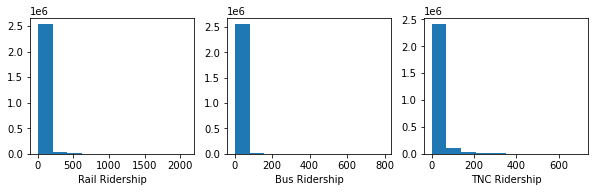

In [15]:
fig, ax = plt.subplots(1,3,figsize=(10,2.5))
ax[0].hist(df['count'])
ax[1].hist(df['bus_count'])
ax[2].hist(df['tnc_count'])
ax[0].set_xlabel("Rail Ridership")
ax[1].set_xlabel("Bus Ridership")
ax[2].set_xlabel("TNC Ridership")
print(df[['count','bus_count']].describe())

In [16]:
num_days = df['ts'].max()//96+1
temp_agg = df.groupby('station_id', as_index=False).sum()[['station_id','count','bus_count','tnc_count']]
for c in ['count','bus_count','tnc_count']:
    temp_agg[c] /= num_days
print(num_days)

213


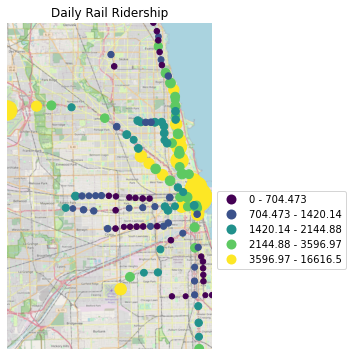

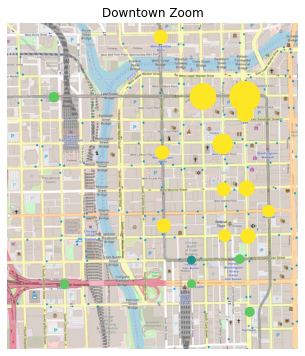

In [17]:
plot(stations, temp_agg, 'STATION_ID', 'station_id', 'count', 'Daily Rail Ridership')

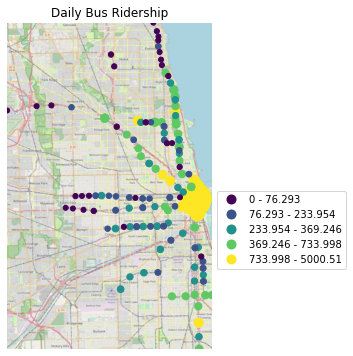

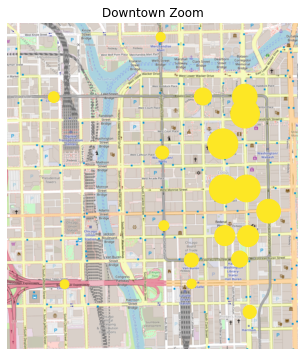

In [18]:
plot(stations, temp_agg, 'STATION_ID', 'station_id', 'bus_count', 'Daily Bus Ridership')

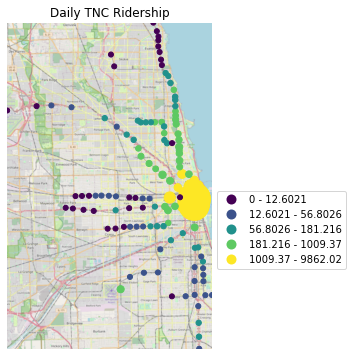

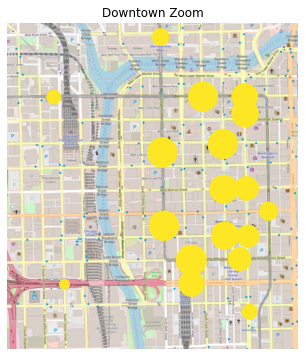

In [19]:
plot(stations, temp_agg, 'STATION_ID', 'station_id', 'tnc_count', 'Daily TNC Ridership')

# Temporal Balance

In [20]:
spatial_agg = df.groupby('ts', as_index=False).sum()[['ts','count','bus_count','tnc_count']]

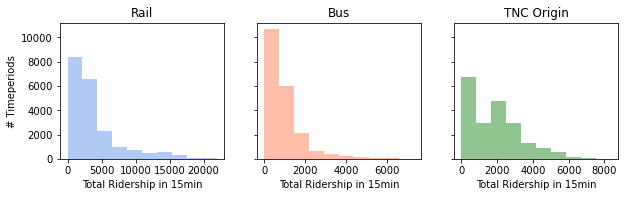

In [22]:
fig, ax = plt.subplots(1, 3, figsize = (10, 2.5), sharey=True)
ax[0].hist(spatial_agg['count'], color='cornflowerblue', alpha=0.5)
ax[1].hist(spatial_agg['bus_count'], color='coral', alpha=0.5)
ax[2].hist(spatial_agg['tnc_count'], color='forestgreen', alpha=0.5)
ax[0].set_ylabel('# Timeperiods')
ax[0].set_xlabel('Total Ridership in 15min')
ax[1].set_xlabel('Total Ridership in 15min')
ax[2].set_xlabel('Total Ridership in 15min')
ax[0].set_title('Rail')
ax[1].set_title('Bus')
ax[2].set_title('TNC Origin')
fig.savefig(data_dir+'rc_all_stations_by_qh_hist.png', bbox_inches='tight')
plt.show()

In [23]:
spatial_agg['qh'] = spatial_agg['ts'] % 96
spatial_agg_mean = spatial_agg.groupby('qh', as_index=False).mean()
spatial_agg_std = spatial_agg.groupby('qh', as_index=False).agg(lambda x: np.std(x))

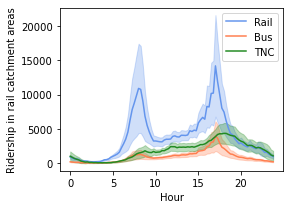

In [24]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(spatial_agg_mean['qh']/4, spatial_agg_mean['count'], color='cornflowerblue', label='Rail')
ax.fill_between(spatial_agg_mean['qh']/4, spatial_agg_mean['count']-spatial_agg_std['count'], 
                spatial_agg_mean['count']+spatial_agg_std['count'], alpha = 0.3, color='cornflowerblue')
ax.plot(spatial_agg_mean['qh']/4, spatial_agg_mean['bus_count'], color='coral', label='Bus')
ax.fill_between(spatial_agg_mean['qh']/4, spatial_agg_mean['bus_count']-spatial_agg_std['bus_count'], 
                spatial_agg_mean['bus_count']+spatial_agg_std['bus_count'], alpha = 0.3, color='coral')
ax.plot(spatial_agg_mean['qh']/4, spatial_agg_mean['tnc_count'], color='forestgreen', label='TNC')
ax.fill_between(spatial_agg_mean['qh']/4, spatial_agg_mean['tnc_count']-spatial_agg_std['tnc_count'], 
                spatial_agg_mean['tnc_count']+spatial_agg_std['tnc_count'], alpha = 0.3, color='forestgreen')
ax.legend()
ax.set_xlabel("Hour")
ax.set_ylabel("Ridership in rail catchment areas");
fig.savefig(data_dir+'rc_all_stations_by_qh.png', bbox_inches='tight')

# Percent zeros

In [25]:
print("pct zeros in rail:  %.3f" % (np.mean(df['count'] == 0)))
print("pct zeros in bus: %.3f" % (np.mean(df['bus_count'] == 0)))
print("pct zeros in tnc:  %.3f" % (np.mean(df['tnc_count'] == 0)))

pct zeros in rail:  0.000
pct zeros in bus: 0.362
pct zeros in tnc:  0.486


# Deviation from Historical Average

In [26]:
numtimeperiods = 96
df['day'] = df['ts']//96
df['interval15'] = (df['ts'] % 96) 

In [27]:
numdays = np.max(df['day'])+1
start_date = datetime.date(2019, 9, 30)
datelist = [start_date + datetime.timedelta(days = x) for x in range(numdays)]
dowlist = [d.weekday() for d in datelist]

daynumlist = np.arange(numdays)
datedict = dict(zip(daynumlist, datelist))
dowdict = dict(zip(daynumlist, dowlist))

df['date'] = df['day'].map(datedict)
df['dow'] = df['day'].map(dowdict)
df['weekday'] = df['dow'] < 5

In [28]:
his_avg = df.groupby(['weekday','interval15','station_id'], as_index=False).mean()\
            [['weekday','interval15','station_id','count','bus_count','tnc_count']]
his_avg.columns = ['weekday','interval15','station_id','rail_ha','bus_ha','tnc_ha']

In [29]:
df = pd.merge(df, his_avg, on=['weekday','interval15','station_id'])

In [30]:
df['rail_dev'] = np.abs(df['count']-df['rail_ha']) / df['rail_ha']
df['bus_dev'] = np.abs(df['bus_count']-df['bus_ha']) / df['bus_ha']
df['tnc_dev'] = np.abs(df['tnc_count']-df['tnc_ha']) / df['tnc_ha']

In [31]:
df[df['bus_dev'] == np.infty] = np.NaN
df[df['tnc_dev'] == np.infty] = np.NaN

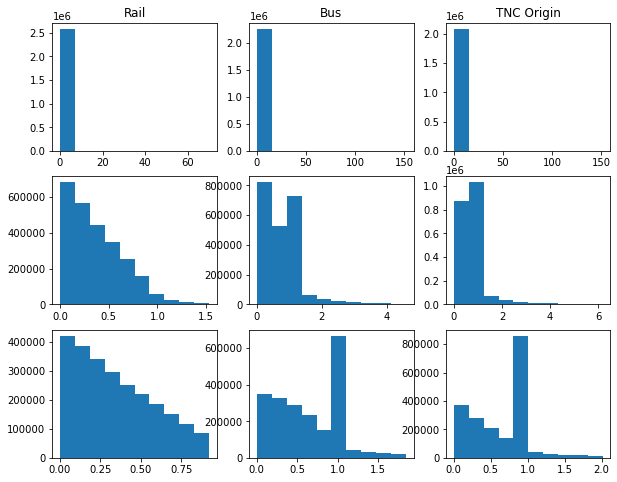

In [32]:
fig, ax = plt.subplots(3, 3, figsize = (10, 8))
ax[0,0].hist(df['rail_dev'])
ax[1,0].hist(df[(np.abs(df['rail_dev'])<np.percentile(np.abs(df['rail_dev']), 99))]['rail_dev'])
ax[2,0].hist(df[(np.abs(df['rail_dev'])<np.percentile(np.abs(df['rail_dev']), 95))]['rail_dev'])

ax[0,0].set_title('Rail')
ax[0,1].set_title('Bus')
ax[0,2].set_title('TNC Origin')

ax[0,1].hist(df['bus_dev'])
ax[1,1].hist(df[(np.abs(df['bus_dev'])<np.nanpercentile(np.abs(df['bus_dev']), 99))]['bus_dev'])
ax[2,1].hist(df[(np.abs(df['bus_dev'])<np.nanpercentile(np.abs(df['bus_dev']), 95))]['bus_dev'])

ax[0,2].hist(df['tnc_dev'])
ax[1,2].hist(df[(np.abs(df['tnc_dev'])<np.nanpercentile(np.abs(df['tnc_dev']), 99))]['tnc_dev'])
ax[2,2].hist(df[(np.abs(df['tnc_dev'])<np.nanpercentile(np.abs(df['tnc_dev']), 95))]['tnc_dev']);